# HW7 (Jin Kim)

I bring much of the settings from the lecture notes.

To state the conclusion upfront, I have accomplished a much smaller RMSE of **(0.008185592)** with the following features and methods:

**1. Factors** (for each chain):
-  Recent returns (1 hour) 
-  Rolling sum of returns (3 hours) 
-  Rolling volatility of returns (3 hours)
-  Rolling (pseudo) Sharpe-ratio (3 hours)
   (p.s. used PCA on ETH chain coins (AAVE, COMP, CRV, ETH) to reduce them to a single dimension)

**2. Methods**:
-  Increase the maximum number of coins (chains) allowed as factors from 2 through 6 (fyi, total: 8 chains)
-  Hyperparameter Optimization on each of 5 notable models
-  Use ensemble decision making algorithm

Particularly, I focus on  **chains** rather than **coins** as source of factors. Therefore as noted for 5th listed factor, I reduce the 4 coins on the ETH chain to a single dimension (other coins are one-to-one correspondent to their respective chains). Moreover, since most models will not readily be able to multiply or divide between factors during the modelling process, I also add a pseudo Sharpe-ratio.

After testing, the chains chosen were AVAX, ADA, ATOM, BTC, USDT and so their related factors were used. Therefore, the model had a total of 5*4=20 factors. Ridge regression with further PCA was considered as the model and hyperparameter optimization was conducted for the related parameters for Ridge's alpha and PCA's dimension.

Though I chose to combine all above without individual analysis, ablation test for each feature or method to see which contributed the most to the improvement would also an interersting task.

In [238]:
data_location = 'sqlite:///../../data/data.db'

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from functools import reduce
from sklearn.decomposition import PCA

import pickle

In [240]:
def vol_ohlc(df, lookback=3):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [241]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [242]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

Note that there are multiple coins for ETH. They will later be dimension reduced to represent ETH in single dimension.

In [243]:
ohlc.groupby(['chain','token']).size()

chain  token
ADA    ADA      1057
ATOM   ATOM     1057
AVAX   AVAX     1057
BTC    BTC      1057
DOT    DOT      1057
ETH    AAVE     1057
       COMP     1057
       CRV      1057
       ETH      1057
SOL    SOL      1057
USDT   USDT     1057
dtype: int64

## Data formatting

From here on, I try the following 2 among the 4 previously mentioned methods
-  Engineered the features to consider auto-regressive terms 
-  Used PCA to reduce the data for coins on the ETH chain to a single dimension. (one for each of ret and vol)

In [244]:
tokens = ohlc.token.unique()

In [282]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [283]:
X.shape

(1057, 22)

In [284]:
ETH_tokens = ohlc[ohlc['chain'] == 'ETH'].token.unique()
ETH_tokens

array(['ETH', 'CRV', 'AAVE', 'COMP'], dtype=object)

In [285]:
ret_ETHs = list(map(lambda x: f"ret_{x}", ETH_tokens))
vol_ETHs = list(map(lambda x: f"vol_{x}", ETH_tokens))

In [286]:
X.fillna(0, inplace = True)

In [287]:
pca = PCA(n_components=1)

I name the new PCA'ed factor as ETHS to represent that it is from the ETH chain.

In [288]:
X['vol_ETHS'] = pca.fit_transform(X[vol_ETHs])
X['ret_ETHS'] = pca.fit_transform(X[ret_ETHs])

In [289]:
X.drop(ret_ETHs, axis=1, inplace=True)
X.drop(vol_ETHs, axis=1, inplace=True)

In [290]:
X.columns

Index(['vol_BTC', 'ret_BTC', 'vol_USDT', 'ret_USDT', 'vol_SOL', 'ret_SOL',
       'vol_ADA', 'ret_ADA', 'vol_DOT', 'ret_DOT', 'vol_AVAX', 'ret_AVAX',
       'vol_ATOM', 'ret_ATOM', 'vol_ETHS', 'ret_ETHS'],
      dtype='object')

In [291]:
factors = set(list(map(lambda x: x[4:], X.columns)))
factors

{'ADA', 'ATOM', 'AVAX', 'BTC', 'DOT', 'ETHS', 'SOL', 'USDT'}

Creating the required factors. Note that I append the number "3" at the back of "ret" to show that it is the cumulative return from the last 3 hours. 

In [292]:
for factor in factors:
    X[f'ret3_{factor}']= X[f'ret_{factor}'].rolling(3).sum()
    X[f'ret3/vol_{factor}']= X[f'ret3_{factor}']/X[f'vol_{factor}'] # this refers to the pseudo Sharpe-ratio

In [293]:
X.columns

Index(['vol_BTC', 'ret_BTC', 'vol_USDT', 'ret_USDT', 'vol_SOL', 'ret_SOL',
       'vol_ADA', 'ret_ADA', 'vol_DOT', 'ret_DOT', 'vol_AVAX', 'ret_AVAX',
       'vol_ATOM', 'ret_ATOM', 'vol_ETHS', 'ret_ETHS', 'ret3_ATOM',
       'ret3/vol_ATOM', 'ret3_USDT', 'ret3/vol_USDT', 'ret3_BTC',
       'ret3/vol_BTC', 'ret3_SOL', 'ret3/vol_SOL', 'ret3_AVAX',
       'ret3/vol_AVAX', 'ret3_ADA', 'ret3/vol_ADA', 'ret3_DOT', 'ret3/vol_DOT',
       'ret3_ETHS', 'ret3/vol_ETHS'],
      dtype='object')

This is ad-hoc but I noticed that using data from too early did not help much in robustness, so cut some data where necessary.

In [294]:
y = X.ret_SOL.shift(-1)[10:-1]
X = X[10:-1]

In [295]:
X.head()

,vol_BTC,ret_BTC,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,vol_DOT,ret_DOT,...,ret3_SOL,ret3/vol_SOL,ret3_AVAX,ret3/vol_AVAX,ret3_ADA,ret3/vol_ADA,ret3_DOT,ret3/vol_DOT,ret3_ETHS,ret3/vol_ETHS
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 10:00:00,0.155573,0.000486,0.002483,0.0001,0.226839,0.003062,0.213095,0.006828,0.210319,0.017386,...,0.002033,0.008963,0.013486,0.094943,0.024173,0.113439,0.029665,0.141047,-0.029823,0.442093
2021-11-01 11:00:00,0.106659,0.004960,0.002509,0.0000,0.244578,-0.004466,0.205342,-0.002411,0.221997,0.015889,...,-0.013622,-0.055696,0.002733,0.020339,0.004164,0.020278,0.031964,0.143985,-0.008784,0.110494
2021-11-01 12:00:00,0.093877,-0.007029,0.002215,0.0000,0.205791,-0.010663,0.205213,-0.004885,0.218987,-0.000312,...,-0.012067,-0.058636,0.001036,0.007664,-0.000468,-0.002280,0.032963,0.150526,-0.008452,0.251798
2021-11-01 13:00:00,0.105910,0.000391,0.001876,0.0000,0.178879,-0.002636,0.121835,-0.002733,0.150777,0.012503,...,-0.017765,-0.099311,-0.011257,-0.079868,-0.010029,-0.082314,0.028080,0.186238,0.000546,0.013801
2021-11-01 14:00:00,0.108033,0.001962,0.001842,0.0000,0.178898,-0.001640,0.120990,0.003907,0.350514,0.056328,...,-0.014938,-0.083500,-0.007156,-0.050066,-0.003710,-0.030664,0.068520,0.195483,-0.008604,-0.141816


Now let's go straight into modelling with our factors.

In [296]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [297]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [298]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

Though I do not show every case, the Ridge model with some PCA seemed to be best so I focus on this combination and test it for differnet types of chain factors. For conciseness, I only print those that outperform the past seen case.

In [299]:
best = -1
for fac1 in factors:
    pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}'])),
    ('scale', StandardScaler()),
    #('pca', PCA(n_components=6)),
    ('model', Ridge(alpha=1))
    ])
    
    if len(fac1) == 3: fac1 = fac1 + ' '
    
    rmse = evaluate_model(pipeline, X, y)
    
    if rmse > best:
        best = rmse
        print(f"ret, ret3, ret3/vol, vol for {fac1}: {rmse}")

ret, ret3, ret3/vol, vol for ATOM: -0.008434975488432904
ret, ret3, ret3/vol, vol for AVAX: -0.008365209227834233


In [300]:
best = -1
for fac1,fac2 in list(itertools.combinations(factors,2)):
    pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}'])),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=6)),
    ('model', Ridge(alpha=0.5))
    ])
    
    if len(fac1) == 3: fac1 = fac1 + ' '
    if len(fac2) == 3: fac2 = fac2 + ' '
    
    rmse = evaluate_model(pipeline, X, y)
    
    if rmse > best:
        best = rmse
        print(f"ret, ret3, ret3/vol, vol for {fac1}, {fac2}: {rmse}")

ret, ret3, ret3/vol, vol for ATOM, USDT: -0.008443320815080146
ret, ret3, ret3/vol, vol for ATOM, BTC : -0.0084314664627261
ret, ret3, ret3/vol, vol for ATOM, AVAX: -0.008317407621101332
ret, ret3, ret3/vol, vol for BTC , AVAX: -0.008316920497649021
ret, ret3, ret3/vol, vol for SOL , AVAX: -0.008297880830998073
ret, ret3, ret3/vol, vol for AVAX, ADA : -0.008257794136966333


In [301]:
best = -1
for fac1,fac2,fac3 in list(itertools.combinations(factors,3)):
    pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}'])),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('model', Ridge(alpha=0.5))
    ])
    
    if len(fac1) == 3: fac1 = fac1 + ' '
    if len(fac2) == 3: fac2 = fac2 + ' '
    if len(fac3) == 3: fac3 = fac3 + ' '
    
    rmse = evaluate_model(pipeline, X, y)
    
    if rmse > best:
        best = rmse
        print(f"ret, ret3, ret3/vol, vol for {fac1}, {fac2}, {fac3}: {rmse}")

ret, ret3, ret3/vol, vol for ATOM, USDT, BTC : -0.00844871760206593
ret, ret3, ret3/vol, vol for ATOM, USDT, AVAX: -0.008388956209346403
ret, ret3, ret3/vol, vol for ATOM, BTC , AVAX: -0.008288013933559229
ret, ret3, ret3/vol, vol for ATOM, SOL , AVAX: -0.008282936365120657
ret, ret3, ret3/vol, vol for BTC , AVAX, ADA : -0.008250498556809881
ret, ret3, ret3/vol, vol for AVAX, ADA , ETHS: -0.008243042405917224


In [302]:
best = -1
for fac1,fac2,fac3,fac4 in list(itertools.combinations(factors,4)):
    pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}',
                                          f'ret_{fac4}',f'ret3_{fac4}',f'ret3/vol_{fac4}',f'vol_{fac4}'])),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=9)),
    ('model', Ridge(alpha=0.5))
    ])
    
    if len(fac1) == 3: fac1 = fac1 + ' '
    if len(fac2) == 3: fac2 = fac2 + ' '
    if len(fac3) == 3: fac3 = fac3 + ' '
    if len(fac4) == 3: fac4 = fac4 + ' '
    
    rmse = evaluate_model(pipeline, X, y)
    
    if rmse > best:
        best = rmse
        print(f"ret, ret3, ret3/vol, vol for {fac1}, {fac2}, {fac3}, {fac4}: {rmse}")

ret, ret3, ret3/vol, vol for ATOM, USDT, BTC , SOL : -0.008476623154782075
ret, ret3, ret3/vol, vol for ATOM, USDT, BTC , AVAX: -0.008430269244669292
ret, ret3, ret3/vol, vol for ATOM, USDT, AVAX, ADA : -0.008420845837566665
ret, ret3, ret3/vol, vol for ATOM, USDT, AVAX, DOT : -0.008411343886220448
ret, ret3, ret3/vol, vol for ATOM, USDT, AVAX, ETHS: -0.008393525437807218
ret, ret3, ret3/vol, vol for ATOM, BTC , AVAX, ADA : -0.008279683125108453
ret, ret3, ret3/vol, vol for ATOM, SOL , AVAX, ADA : -0.008279036848419538
ret, ret3, ret3/vol, vol for ATOM, AVAX, ADA , ETHS: -0.008269288842424805
ret, ret3, ret3/vol, vol for BTC , AVAX, ADA , ETHS: -0.008222209990879106


In [303]:
best = -1
for fac1,fac2,fac3,fac4,fac5 in list(itertools.combinations(factors,5)):
    pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}',
                                          f'ret_{fac4}',f'ret3_{fac4}',f'ret3/vol_{fac4}',f'vol_{fac4}',
                                          f'ret_{fac5}',f'ret3_{fac5}',f'ret3/vol_{fac5}',f'vol_{fac5}'])),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('model', Ridge(alpha=0.5))
    ])
    
    if len(fac1) == 3: fac1 = fac1 + ' '
    if len(fac2) == 3: fac2 = fac2 + ' '
    if len(fac3) == 3: fac3 = fac3 + ' '
    if len(fac4) == 3: fac4 = fac4 + ' '
    if len(fac5) == 3: fac5 = fac5 + ' '
    
    rmse = evaluate_model(pipeline, X, y)
    
    if rmse > best:
        best = rmse
        print(f"ret, ret3, ret3/vol, vol for {fac1}, {fac2}, {fac3}, {fac4}, {fac5}: {rmse}")

ret, ret3, ret3/vol, vol for ATOM, USDT, BTC , SOL , AVAX: -0.008239442470214587
ret, ret3, ret3/vol, vol for ATOM, USDT, BTC , AVAX, ADA : -0.00818579660534539


In [304]:
best = -1
for fac1,fac2,fac3,fac4,fac5,fac6 in list(itertools.combinations(factors,6)):
    pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}',
                                          f'ret_{fac4}',f'ret3_{fac4}',f'ret3/vol_{fac4}',f'vol_{fac4}',
                                          f'ret_{fac5}',f'ret3_{fac5}',f'ret3/vol_{fac5}',f'vol_{fac5}',
                                          f'ret_{fac6}',f'ret3_{fac6}',f'ret3/vol_{fac6}',f'vol_{fac6}'])),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('model', Ridge(alpha=0.5))
    ])
    
    if len(fac1) == 3: fac1 = fac1 + ' '
    if len(fac2) == 3: fac2 = fac2 + ' '
    if len(fac3) == 3: fac3 = fac3 + ' '
    if len(fac4) == 3: fac4 = fac4 + ' '
    if len(fac5) == 3: fac5 = fac5 + ' '
    if len(fac6) == 3: fac6 = fac6 + ' '
    
    rmse = evaluate_model(pipeline, X, y)
    
    if rmse > best:
        best = rmse
        print(f"ret, ret3, ret3/vol, vol for {fac1}, {fac2}, {fac3}, {fac4}, {fac5}, {fac6}: {rmse}")

ret, ret3, ret3/vol, vol for ATOM, USDT, BTC , SOL , AVAX, ADA : -0.008256245075742874
ret, ret3, ret3/vol, vol for ATOM, USDT, BTC , AVAX, ADA , ETHS: -0.008242447867563731
ret, ret3, ret3/vol, vol for USDT, BTC , SOL , AVAX, ADA , ETHS: -0.008236737336932736


Note that we have 8 chains. I thought that testing on 7 or 8 chains would only fuzz interpretation due to its overflowing numer of parameters. So I keep it up to 6 chains. Now I perform hyperparameter optimization on each case from 2 chains to 6 chains through grid search

In [305]:
from sklearn.model_selection import GridSearchCV

fac1 = 'AVAX'
fac2 = 'ADA'

print(f'Grid search on model with factors: {fac1}, {fac2}')

pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}'])),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': np.linspace(4,8,5).astype(int),
    'model__alpha': np.linspace(0,1,6)
}, scoring=scorer, refit=True, cv=cv, verbose = 1)
search.fit(X, y)
best_model_2 = search.best_estimator_

Grid search on model with factors: AVAX, ADA
Fitting 209 folds for each of 30 candidates, totalling 6270 fits


In [306]:
fac1 = 'AVAX'
fac2 = 'ADA'
fac3 = 'ETHS'

print(f'Grid search on model with factors: {fac1}, {fac2}, {fac3}')

pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}'])),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': np.linspace(6,12,7).astype(int),
    'model__alpha': np.linspace(0,1,6)
}, scoring=scorer, refit=True, cv=cv, verbose = 1)
search.fit(X, y)
best_model_3 = search.best_estimator_

Grid search on model with factors: AVAX, ADA, ETHS
Fitting 209 folds for each of 42 candidates, totalling 8778 fits


In [307]:
fac1 = 'AVAX'
fac2 = 'ADA'
fac3 = 'ETHS'
fac4 = 'BTC'

print(f'Grid search on model with factors: {fac1}, {fac2}, {fac3}, {fac4}')

pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}',
                                          f'ret_{fac4}',f'ret3_{fac4}',f'ret3/vol_{fac4}',f'vol_{fac4}'])),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': np.linspace(8,16,9).astype(int),
    'model__alpha': np.linspace(0,1,6)
}, scoring=scorer, refit=True, cv=cv, verbose = 1)
search.fit(X, y)
best_model_4 = search.best_estimator_

Grid search on model with factors: AVAX, ADA, ETHS, BTC
Fitting 209 folds for each of 54 candidates, totalling 11286 fits


In [308]:
fac1 = 'AVAX'
fac2 = 'ADA'
fac3 = 'BTC'
fac4 = 'ATOM'
fac5 = 'USDT'

print(f'Grid search on model with factors: {fac1}, {fac2}, {fac3}, {fac4}, {fac5}') 
    
pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}',
                                          f'ret_{fac4}',f'ret3_{fac4}',f'ret3/vol_{fac4}',f'vol_{fac4}',
                                          f'ret_{fac5}',f'ret3_{fac5}',f'ret3/vol_{fac5}',f'vol_{fac5}'])),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': np.linspace(10,20,11).astype(int),
    'model__alpha': np.linspace(0,1,6)
}, scoring=scorer, refit=True, cv=cv, verbose = 1)
search.fit(X, y)
best_model_5 = search.best_estimator_

Grid search on model with factors: AVAX, ADA, BTC, ATOM, USDT
Fitting 209 folds for each of 66 candidates, totalling 13794 fits


In [309]:
fac1 = 'AVAX'
fac2 = 'ADA'
fac3 = 'BTC'
fac4 = 'ETHS'
fac5 = 'USDT'
fac6 = 'SOL'

print(f'Grid search on model with factors: {fac1}, {fac2}, {fac3}, {fac4}, {fac5}, {fac6}') 

pipeline = Pipeline([
    ('feature_selector', FeatureSelector([f'ret_{fac1}',f'ret3_{fac1}',f'ret3/vol_{fac1}',f'vol_{fac1}',
                                          f'ret_{fac2}',f'ret3_{fac2}',f'ret3/vol_{fac2}',f'vol_{fac2}',
                                          f'ret_{fac3}',f'ret3_{fac3}',f'ret3/vol_{fac3}',f'vol_{fac3}',
                                          f'ret_{fac4}',f'ret3_{fac4}',f'ret3/vol_{fac4}',f'vol_{fac4}',
                                          f'ret_{fac5}',f'ret3_{fac5}',f'ret3/vol_{fac5}',f'vol_{fac5}',
                                          f'ret_{fac6}',f'ret3_{fac6}',f'ret3/vol_{fac6}',f'vol_{fac6}'])),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': np.linspace(12,24,13).astype(int),
    'model__alpha': np.linspace(0,1,6)
}, scoring=scorer, refit=True, cv=cv, verbose = 1)
search.fit(X, y)
best_model_6 = search.best_estimator_

Grid search on model with factors: AVAX, ADA, BTC, ETHS, USDT, SOL
Fitting 209 folds for each of 78 candidates, totalling 16302 fits


Now before seeing the individual results, I also try creating and testing a ensemble version of all the 5 models above. For ensemble decision, since we are dealing with continuous data, I use the median value of the predictions as the final y predictions.

In [355]:
# scoreing function for the ensemble model
def evaluate_model_ens(model2,model3,model4,model5,model6, X, y, test_size=0.2):
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        model2.fit(X_train, y_train)
        model3.fit(X_train, y_train)
        model4.fit(X_train, y_train)
        model5.fit(X_train, y_train)
        model6.fit(X_train, y_train)
        
        predictions = np.concatenate((model2.predict(X_test), 
                                      model3.predict(X_test), 
                                      model4.predict(X_test),
                                      model5.predict(X_test),
                                      model6.predict(X_test)))
        
        predictions = predictions.reshape(len(X_test),5)
        
        y_pred = np.median(predictions, axis = 1)
        
        score = mean_squared_error(y_test, y_pred, squared=False)
        scores.append(score)
      
    return -np.mean(scores)

In [356]:
ensemble_rmse = evaluate_model_ens(best_model_2,
                                   best_model_3,
                                   best_model_4,
                                   best_model_5,
                                   best_model_6, X, y)

In [357]:
print(f'RMSE: {evaluate_model(best_model_2, X, y)} for AVAX, ADA')
print(f'RMSE: {evaluate_model(best_model_3, X, y)} for AVAX, ADA, ETHS')
print(f'RMSE: {evaluate_model(best_model_4, X, y)} for AVAX, ADA, ETHS, BTC')
print(f'RMSE: {evaluate_model(best_model_5, X, y)} for AVAX, ADA, ATOM, BTC, USDT')
print(f'RMSE: {evaluate_model(best_model_6, X, y)} for AVAX, ADA, ETHS, BTC, USDT, SOL')
print(f'RMSE: {ensemble_rmse} for ensemble of all 5 models above')

RMSE: -0.008252753955704649 for AVAX, ADA
RMSE: -0.00824118391758347 for AVAX, ADA, ETHS
RMSE: -0.008221891327546336 for AVAX, ADA, ETHS, BTC
RMSE: -0.008185592084612319 for AVAX, ADA, ATOM, BTC, USDT
RMSE: -0.008219739801605732 for AVAX, ADA, ETHS, BTC, USDT, SOL
RMSE: -0.00818934962015297 for ensemble of all 5 models above


The results show that the ensemble version was not better than the individual best which was model 5 with 5 factors. Therefore we go with the model 5 with factors related to AVAX, ADA, ATOM, BTC, and USDT.

<module 'matplotlib.pyplot' from '/Users/jin/opt/anaconda3/envs/lectures/lib/python3.9/site-packages/matplotlib/pyplot.py'>

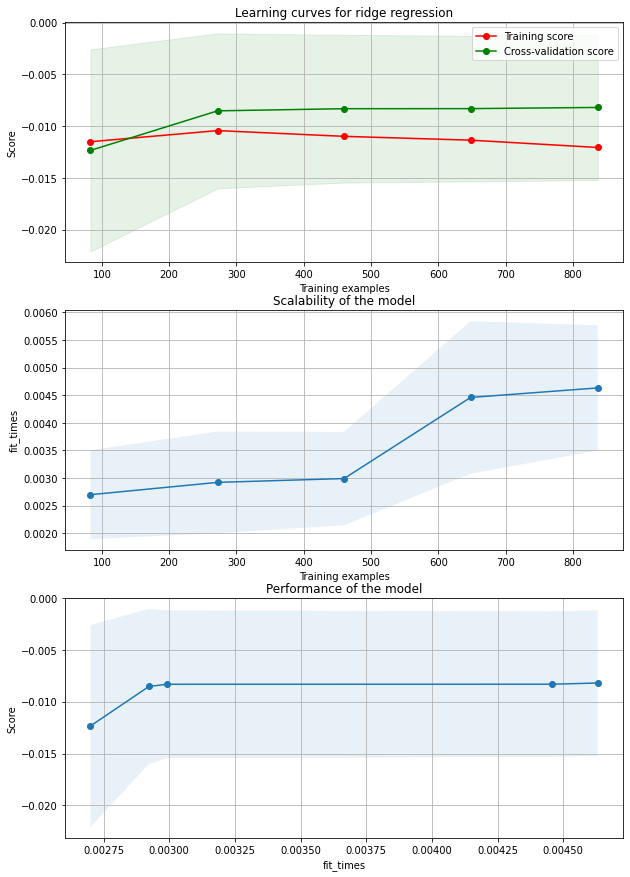

In [358]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model_5, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


Now that we have completed the model, we will need to save it down so that we can load it up in our model.  To do this, we will use pickle

In [359]:
pickle.dump(best_model_5, open('best_model.pkl', 'wb'))

We can verify that this is the same model that we saved:

In [360]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [362]:
loaded_model

Pipeline(steps=[('feature_selector',
                 FeatureSelector(columns=['ret_AVAX', 'ret3_AVAX',
                                          'ret3/vol_AVAX', 'vol_AVAX',
                                          'ret_ADA', 'ret3_ADA', 'ret3/vol_ADA',
                                          'vol_ADA', 'ret_BTC', 'ret3_BTC',
                                          'ret3/vol_BTC', 'vol_BTC', 'ret_ATOM',
                                          'ret3_ATOM', 'ret3/vol_ATOM',
                                          'vol_ATOM', 'ret_USDT', 'ret3_USDT',
                                          'ret3/vol_USDT', 'vol_USDT'])),
                ('scale', StandardScaler()), ('pca', PCA(n_components=12)),
                ('model', Ridge(alpha=0.0))])

In [366]:
evaluate_model(loaded_model, X, y)

-0.008185592084612316

we can now take this model and build a server around it, so that other systems can also now make predictions on the hourly returns of SOL!